# 3 - Benchmarking
This notebook explores the performance of the driftcorrection algorithm as defined in `2 - Driftcorrection` by benchmarking the time it takes to driftcorrect stacks of different numbers of images.

In [1]:
# Needed imports
from Registration import *
import shutil
import xarray as xr
import time
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import os
import scipy.ndimage as ndi

In [2]:
folder = r'./data'
name = '20171120_160356_3.5um_591.4_IVhdr'
original = xr.open_dataset(os.path.join(folder, name + '_detectorcorrected.nc'), chunks={'time': 1})
original = original.Intensity.data

In [3]:
# Define fftsize used for the drift correction algorithm; actual size of the fft is twice this value.
fftsize = 256 // 2

Next, we define the grid of parameters for which we will perform the benchmark and the timings we want to save as an empty `xarray.DataArray`.

**Note**: the parameters noted here will run for several hours at least even on reasonably fast hardware.

In [4]:
iters = np.arange(5)
sigmas = [3, 7, 9, 11, 13, 17]
#strides = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 35, 50, 70,])
strides = np.array([35, 50, 70,])
ts = [0,1,2,3,4]
res = xr.DataArray(np.zeros((len(iters), len(sigmas), len(strides), len(ts))), 
             coords={'i':iters, 'sigma': sigmas, 'strides': strides.astype(np.int32), 't': ts}, 
             dims=['i','sigma', 'strides', 't'])
res.coords

Coordinates:
  * i        (i) int32 0 1 2 3 4
  * sigma    (sigma) int32 3 7 9 11 13 17
  * strides  (strides) int32 35 50 70
  * t        (t) int32 0 1 2 3 4

Before we can start, we connect to the dask-scheduler and upload the used functions

In [5]:
cluster = LocalCluster()
client = Client(cluster)
client.upload_file('Registration.py')
client

C:\ProgramData\Anaconda3\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:49179 Dashboard: http://127.0.0.1:49182/status,Cluster Workers: 4 Cores: 8 Memory: 34.23 GB


In [6]:
# Inferring output dtype is not supported in dask yet, so we need original.dtype here.
@da.as_gufunc(signature="(i,j),(2)->(i,j)", output_dtypes=original.dtype, vectorize=True)
def shift_images(image, shift):
    """Shift `image` by `shift` pixels."""
    return ndi.shift(image, shift=shift, order=1)

In [7]:
tstart = time.time()
t = np.zeros((5,))
for stride in strides:
    for sigma in sigmas:
        for i in iters:
            t[0] = time.time() - tstart
            #start, stride, dE = 40, 1, 10
            start, stop, dE = 40, 740, 10
            #stop = start + n
            Eslice = slice(start, stop, stride)
            sliced_data = original[Eslice,...].rechunk({0:dE})
            sobel = crop_and_filter(sliced_data, 
                                    sigma=sigma, finalsize=2*fftsize)
            sobel = sobel - sobel.mean(axis=(1,2), keepdims=True)  
            Corr = dask_cross_corr(sobel)
            weights, argmax = max_and_argmax(Corr)
            W, DX_DY = calculate_halfmatrices(weights, argmax, fftsize=fftsize)
            t[1] = (time.time() - (t[0]+tstart))
            coords = np.arange(sliced_data.shape[0])
            coords, weightmatrix, DX, DY, row_mask = threshold_and_mask(0.0, W, DX_DY, coords=coords)
            t[2] = (time.time() - (t[0]+tstart))
            dx, dy = calc_shift_vectors(DX, DY, weightmatrix)
            t[3] = (time.time() - (t[0]+tstart))
            shifts = np.stack(interp_shifts(coords, [dx, dy], n=sliced_data.shape[0]), axis=1)
            neededMargins = np.ceil(shifts.max(axis=0)).astype(int)
            shifts = da.from_array(shifts, chunks=(dE,-1))
            padded = da.pad(sliced_data, 
                            ((0, 0), 
                             (0, neededMargins[0]), 
                             (0, neededMargins[1])
                            ),
                            mode='constant'
                           )
            corrected = shift_images(padded.rechunk({1:-1, 2:-1}), shifts)
            corrected[:sliced_data.shape[0]].to_zarr(r'./tempresult.zarr', overwrite=True)
            t[4] = (time.time() - (t[0]+tstart))
            res.loc[dict(i=i,sigma=sigma,strides=stride)] = t
            shutil.rmtree(r'tempresult.zarr')
            print(f"t_tot = {t[0]:.2f}\nn = {corrected.shape[0]}, times = {t[1:]}")
    res.to_netcdf(os.path.join(folder, 'benchmarkresult.nc'))

t_tot = 0.00
n = 20, times = [2.03142834 2.03142834 2.89860201 4.12788677]
t_tot = 4.14
n = 20, times = [0.98663664 0.98663664 1.41778874 2.66311646]
t_tot = 6.82
n = 20, times = [1.15208054 1.15208054 1.69352651 2.76438689]
t_tot = 9.59
n = 20, times = [1.09893632 1.09993958 1.56718779 2.5989449 ]
t_tot = 12.20
n = 20, times = [1.01070023 1.01170254 1.40876555 2.45054889]
t_tot = 14.67
n = 20, times = [1.15709257 1.15709257 1.60830212 2.68417358]
t_tot = 17.37
n = 20, times = [1.10996652 1.10996652 1.52507448 2.59092784]
t_tot = 19.98
n = 20, times = [1.13703799 1.13804054 1.58924556 2.64607   ]
t_tot = 22.64
n = 20, times = [1.14104986 1.14104986 1.63537025 2.72327757]
t_tot = 25.38
n = 20, times = [1.11598349 1.11598349 1.66043758 2.72728872]
t_tot = 28.12
n = 20, times = [1.13804173 1.13804173 1.61832476 2.67815709]
t_tot = 30.81
n = 20, times = [1.08991337 1.08991337 1.57821965 2.67365479]
t_tot = 33.50
n = 20, times = [1.00067282 1.00067282 1.40876389 2.50569439]
t_tot = 36.01
n 

## Plotting
We can plot the results of either the benchmark run above or the reference results. This is done using `xarray` plotting interface on the created datasets. First we do some cleaning up of the data and recombination:

In [13]:
data = xr.open_dataarray(os.path.join(folder, 'benchmarkresult_reference_int32.nc')) # One can remove _reference to view newly generated results

In [11]:
# We are interested in the times each individual step took, 
# instead of the time upto that step which is saved, so take a diff

data = xr.concat([data.isel(t=1), data.isel(t=slice(2,5)).diff(dim='t', label='lower'), data.isel(t=4)], 't')
data.attrs['long_name'] = 'Run time'
data.attrs['units'] = 's'

# Define a nicer 'Phase' of the algorithm dimension instead of 't', as it is saved in the file.
data.coords['Phase'] = ('t', ['Filter+CC', 'Least Squares', 'Shift and write', 'Total']) 
data = data.swap_dims({'t': 'Phase'})
data.coords['N'] = ('strides', 700//data.coords['strides'])
data = data.swap_dims({'strides': 'N'})

And now we are ready to actually plot.

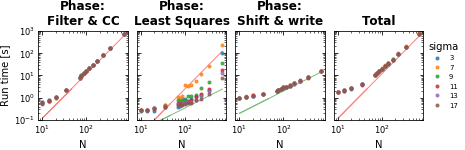

In [12]:
#Take the mean over the iterations
red = data.mean(dim='i', keep_attrs=True)

facetgrid = red.plot.line('.', col='Phase', hue='sigma', 
                          yscale='log', xscale='log', ylim=[0.1, 1000], 
                          figsize=[6,2], alpha=0.8)

# Add guidelines in red for quadratic in green for linear.
facetgrid.axes[0,0].plot(data['N'], 0.0012*data['N']**2, c='red', zorder=0, alpha=0.5)
facetgrid.axes[0,1].plot(data['N'], 0.00025*data['N']**2, c='red', zorder=0, alpha=0.5)
facetgrid.axes[0,1].plot(data['N'], 0.0035*data['N'], c='green', zorder=0, alpha=0.5)
facetgrid.axes[0,2].plot(data['N'], 0.02*data['N'], c='green', zorder=0, alpha=0.5)
facetgrid.axes[0,3].plot(data['N'], 0.0012*data['N']**2, c='red', zorder=0, alpha=0.5)
# Replace default plot titles with a somewhat nicer version
facetgrid.axes[0,0].set_title('Phase:\nFilter & CC')
facetgrid.axes[0,1].set_title('Phase:\nLeast Squares')
facetgrid.axes[0,2].set_title('Phase:\nShift & write')
facetgrid.axes[0,3].set_title('Total')
plt.subplots_adjust(top=0.8, bottom=0.18, left=0.08, wspace=0.1)
#plt.savefig('timebench.pdf')